# Labolatorium nr 6

#### Patryk Klatka


Celem labolatorium było zapoznanie się oraz implementacja struktur danych takich jak trie oraz drzewo sufiksowe z wykorzystaniem algorytmu Ukkonena.

## Import bibliotek

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Zbiór danych wejściowych

In [22]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz"
dataset_1 = "bbb$"
dataset_2 = "aabbabd"
dataset_3 = "ababcd"
dataset_4 = "abaababaabaabaabab$"
dataset_5 = "".join(np.random.choice(list(ALPHABET), 99)) + "$"
dataset_6 = open("1997_714_head.txt", "r").read() + "$"

Obserwacja: Każdy z powyższych tekstów posiada unikalny znak na końcu (marker).

## Implementacja struktury trie w wariancie, w którym kolejne sufiksy dodawane są przez przeszukiwanie głowy od korzenia drzewa

In [23]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                return False
            node = node.children[char]
        return True
    
    @staticmethod
    def build_suffix_trie(text):
        trie = Trie()
        for i in range(len(text)):
            trie.insert(text[i:])
        return trie

## Implementacja struktury trie w wariancie, w którym kolejne sufiksy dodawane są poprzez dodanie kolejnej litery tekstu

In [24]:
class TrieOnlineNode:
    def __init__(self):
        self.children = {}
        self.suffix_link = None

class TrieOnline:
    def __init__(self):
        self.root = TrieOnlineNode()
        self.deepest = self.root

    def insert_letters(self, text):
        for i in range(len(text)):
            a = text[i]
            node = self.deepest
            self.deepest = None
            prev = None

            while node and a not in node.children:
                child = node.children[a] = TrieOnlineNode()
                
                if not self.deepest:
                    self.deepest = child

                if prev:
                    prev.suffix_link = child

                if node == self.root:
                    child.suffix_link = self.root

                prev = child
                node = node.suffix_link

            if node:
                prev.suffix_link = node.children[a]
    
    def search(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                return False
            node = node.children[char]
        return True
    
    @staticmethod
    def build_suffix_trie(text):
        trie = TrieOnline()
        trie.insert_letters(text)
        return trie


## Implementacja drzewa sufiksów - algorytm Ukkonena

In [25]:
class MutableInt:
    def __init__(self, value):
        self.value = value

    def __index__(self):
        return self.value
    
    def __add__(self, other):
        return self.value + other
    
    def __sub__(self, other):
        return self.value - other
    

class Node:
    def __init__(self, start=None, end=None, suffix_link=None):
        self.start = start
        self.end = end
        self.suffix_link = suffix_link
        self.children = {}

    def edge_length(self):
        return self.end - self.start + 1
    
class SuffixTree:
    """Ukkonen's algorithm for constructing suffix tree

    References:
        - https://stackoverflow.com/questions/9452701/ukkonens-suffix-tree-algorithm-in-plain-english
        - https://www.youtube.com/watch?v=aPRqocoBsFQ
        - https://www.geeksforgeeks.org/ukkonens-suffix-tree-construction-part-6/
    """

    def __init__(self, text):
        self.text = text
        self.root = Node(start=-1, end=-1, suffix_link=None)
        self.remaining = 0
        self.previous_node = None
        self.end_pointer = MutableInt(-1) # Represents the last input string character processed so far
        # Active point
        self.active_node = self.root # First active_node will be root
        self.active_edge = -1 # Represeted as input string character index
        self.active_length = 0 # Offset of active_point from head of edge

    def walk_down(self, current_node):
        length = current_node.edge_length()

        if self.active_length >= length:
            # Change active point
            self.active_edge += length
            self.active_length -= length
            self.active_node = current_node
            return True
        
        return False

    def extend_suffix_tree(self, index):
        # Extension rule 1
        self.end_pointer.value = index
        self.remaining += 1
        self.previous_node = None

        while self.remaining > 0:
            if self.active_length == 0:
                self.active_edge = index 

            if self.text[self.active_edge] not in self.active_node.children:
                # Extension rule 2
                self.active_node.children[self.text[self.active_edge]] = Node(start=index, end=self.end_pointer, suffix_link=self.root)

                if self.previous_node is not None:
                    self.previous_node.suffix_link = self.active_node
                    self.previous_node = None
            else:
                # Get the next node at the end of edge starting with active_edge
                next_node = self.active_node.children[self.text[self.active_edge]]
                
                if self.walk_down(next_node):  
                    # Start from the new active_node
                    continue

                # Extension rule 3
                if self.text[next_node.start + self.active_length] == self.text[index]:
                    self.active_length += 1

                    # If a newly created node waiting for it's suffix link to be set
                    if self.previous_node is not None and self.active_node != self.root:
                        self.previous_node.suffix_link = self.active_node
                        self.previous_node = None

                    break

                # New internal node
                internal_node = Node(start=next_node.start, end=next_node.start + self.active_length - 1, suffix_link=self.root)
                self.active_node.children[self.text[self.active_edge]] = internal_node

                # New leaf coming out of new internal node
                internal_node.children[self.text[index]] = Node(start=index, end=self.end_pointer, suffix_link=self.root)
                next_node.start += self.active_length
                internal_node.children[self.text[next_node.start]] = next_node

                if self.previous_node is not None:
                    self.previous_node.suffix_link = internal_node

                self.previous_node = internal_node

            self.remaining -= 1

            # Active point change
            if self.active_node == self.root and self.active_length > 0: 
                self.active_length -= 1
                self.active_edge = index - self.remaining + 1
            elif self.active_node != self.root:  
                self.active_node = self.active_node.suffix_link

    def contains(self, pattern):
        def traverse(node, sub_string):
            if sub_string:
                for char, child in node.children.items():
                    if sub_string.startswith(char):
                        if self.text[child.start:child.end + 1].startswith(sub_string):
                            return child.start - (len(pattern) - len(sub_string))
                
                        return traverse(child, sub_string[child.end - child.start + 1:])
                else:
                    return -1
                
            return node.start - (len(pattern) - len(sub_string))
        
        return traverse(self.root, pattern) >= 0

    @staticmethod
    def build_suffix_tree(text):
        tree = SuffixTree(text)
        for i in range(len(text)):
            tree.extend_suffix_tree(i)
        return tree

## Sprawdzenie poprawności implementacji

In [26]:
# Trie
trie = Trie.build_suffix_trie(dataset_3)
fail_msg = "Trie search failed"
assert trie.search("ATG") == False, fail_msg
assert trie.search("aba") == True, fail_msg
assert trie.search("ba") == True, fail_msg
assert trie.search("ababcd") == True, fail_msg
assert trie.search("ababce") == False, fail_msg


# Trie Online
trie_online = TrieOnline.build_suffix_trie(dataset_3)
fail_msg = "Trie Online search failed"
assert trie_online.search("ATG") == False, fail_msg
assert trie_online.search("aba") == True, fail_msg
assert trie_online.search("ba") == True, fail_msg
assert trie_online.search("ababcd") == True, fail_msg
assert trie_online.search("ababce") == False, fail_msg

# Suffix Tree
suffix_tree = SuffixTree.build_suffix_tree(dataset_3)
fail_msg = "Suffix Tree search failed"
assert suffix_tree.contains("ATG") == False, fail_msg
assert suffix_tree.contains("aba") == True, fail_msg
assert suffix_tree.contains("ba") == True, fail_msg
assert suffix_tree.contains("ababcd") == True, fail_msg
assert suffix_tree.contains("ababce") == False, fail_msg

print("All tests passed")

All tests passed


## Porównanie szybkości działania algorytmów konstruujących struktury danych 

In [27]:
test_cases = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]
search_cases = ["ATG", "aba", "ba", "ababcd", "ababce"]

build_times = [[], [], []]
search_times = [[], [], []]

for dataset in test_cases:
    # Suffix Tree
    start = time.time()
    suffix_tree = SuffixTree.build_suffix_tree(dataset)
    build_times[0].append(time.time() - start)

    for pattern in search_cases:
        start = time.time()
        suffix_tree.contains(pattern)
        search_times[0].append(time.time() - start)

    # Trie
    start = time.perf_counter()
    trie = Trie.build_suffix_trie(dataset)
    build_times[1].append(time.perf_counter() - start)

    for pattern in search_cases:
        start = time.perf_counter()
        trie.search(pattern)
        search_times[1].append(time.perf_counter() - start)

    # Trie Online
    start = time.perf_counter()
    trie_online = TrieOnline.build_suffix_trie(dataset)
    build_times[2].append(time.perf_counter() - start)

    for pattern in search_cases:
        start = time.perf_counter()
        trie_online.search(pattern)
        search_times[2].append(time.perf_counter() - start)

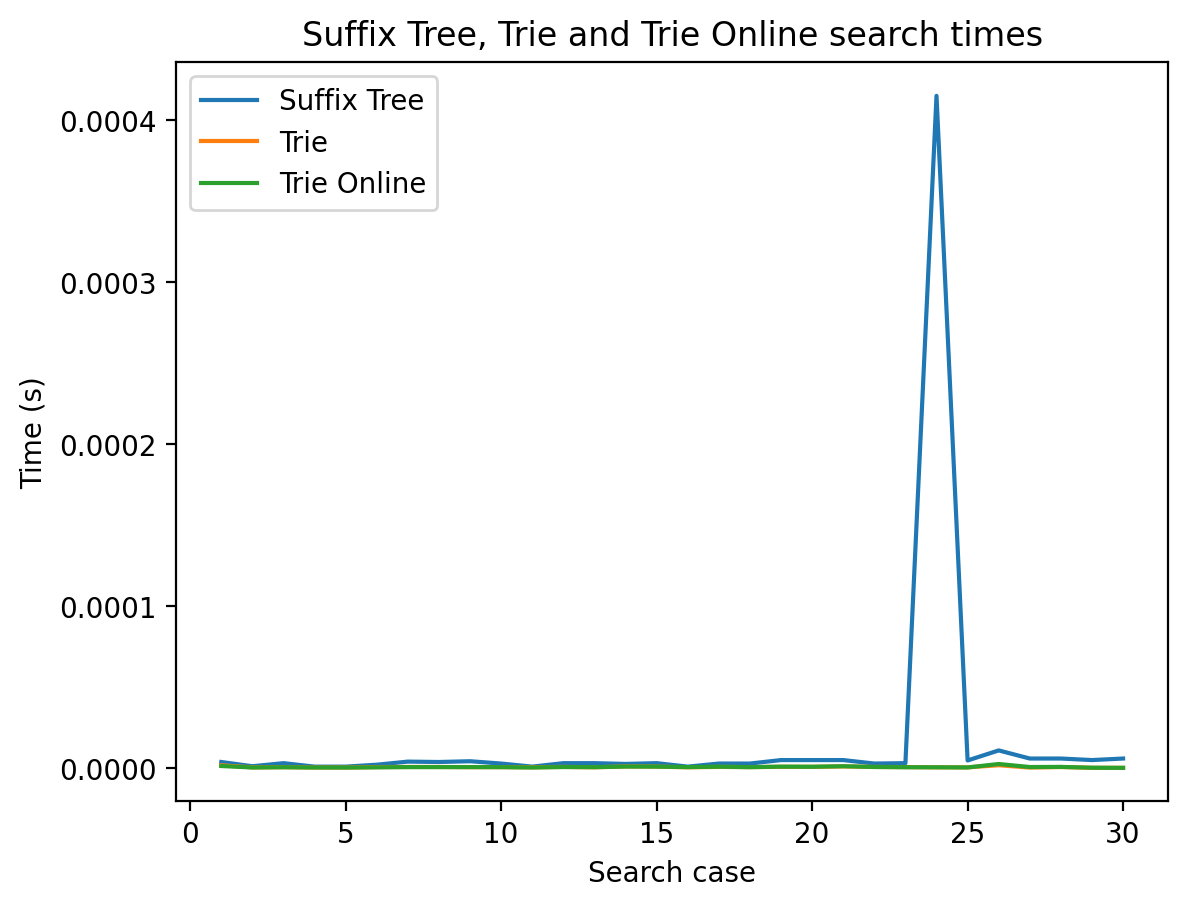

In [9]:
# Plot search results
x_axis_points = np.linspace(1, len(search_times[1]), len(search_times[1]))
plt.title("Suffix Tree, Trie and Trie Online search times")
plt.plot(x_axis_points, search_times[0], label="Suffix Tree")
plt.plot(x_axis_points, search_times[1], label="Trie")
plt.plot(x_axis_points, search_times[2], label="Trie Online")
plt.xlabel("Search case")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

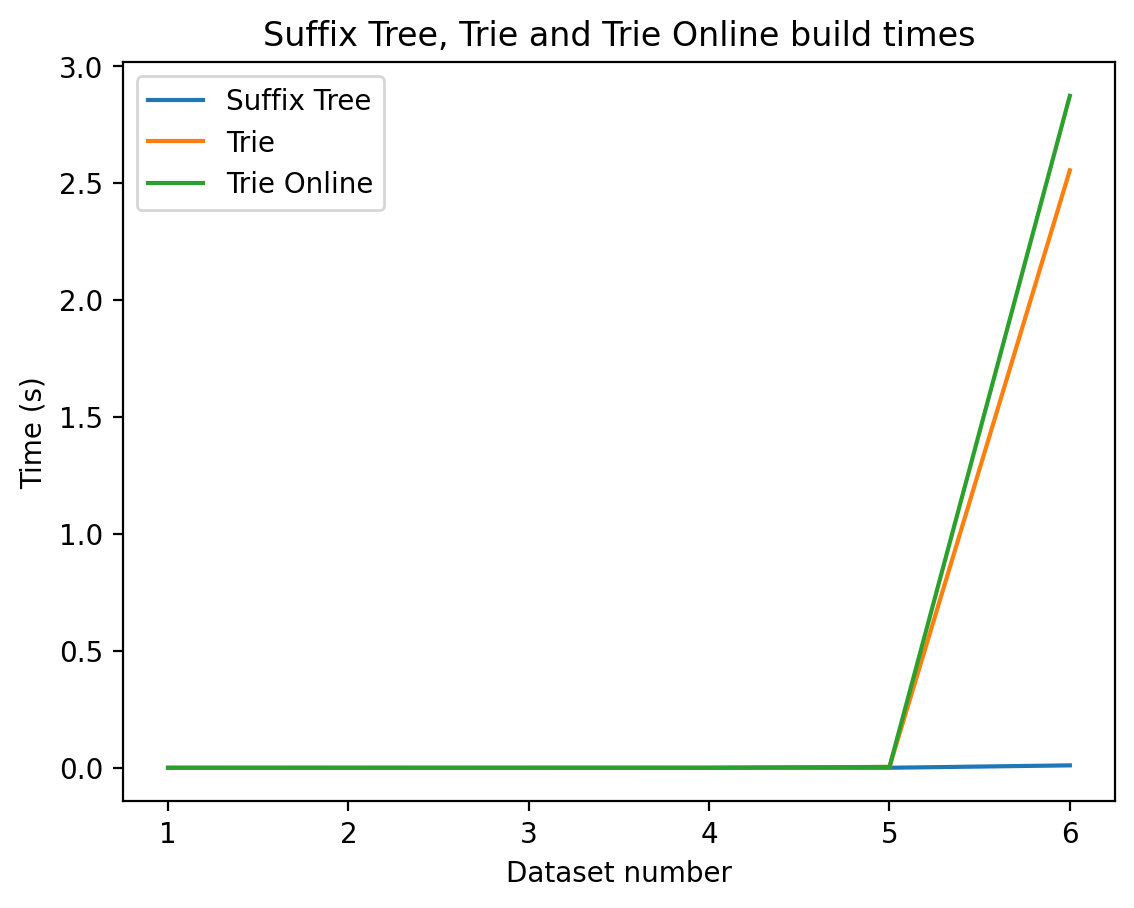

In [8]:
# Plot build results
x_axis_points = np.linspace(1, len(build_times[1]), len(build_times[1]))
plt.title("Suffix Tree, Trie and Trie Online build times")
plt.plot(x_axis_points, build_times[0], label="Suffix Tree")
plt.plot(x_axis_points, build_times[1], label="Trie")
plt.plot(x_axis_points, build_times[2], label="Trie Online")
plt.xlabel("Dataset number")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

## Wnioski

W celu sprawdzenia, która ze struktur danych jest szybsza, zostały wykonane testy, które obejmowały teksty z punktu "Zbiór danych wejściowych". Na wykresie zatytułowanym "Suffix Tree, Trie and Trie Online build times" można zauważyć, że najszybciej tworzy się struktura "Suffix Tree" oparta na algorytmie Ukkonena. Nie jest to nic dziwnego - złożoność obliczeniowa budowy struktury wynosi $O(n)$ (dla stałego alfabetu), gdzie dla trie to już ok. $O(n^2)$. Dla struktur trie dla zestawu danych nr 6 budowa zajęła aż trzy sekundy, gdzie dla drzewa sufiksów setne sekundy. Dodatkowo zostały wykonane testy szybkości metody sprawdzającej czy dany wzorzec występuje w tekście. Wyniki, widoczne na wykresie "Suffix Tree, Trie and Trie Online search times", były zróżnicowane, lecz czasy były tego samego rządu wielkości. Dla jednego przypadku drzewo suffiksów poradziło sobie gorzej, co spowodowało utworzenie widocznej górki na wykresie.